# Images photometry

After an observation is done, a common need is to reduce and extract fluxes from raw FITS images.

In this tutorial you will learn how to process a complete night of raw data from any telescope by building a data reduction [Sequence](prose.Sequence) with prose.

## Simualting data

You can follow this tutorial on your own data or generate a synthetic dataset. As an example, let’s generate a light curve

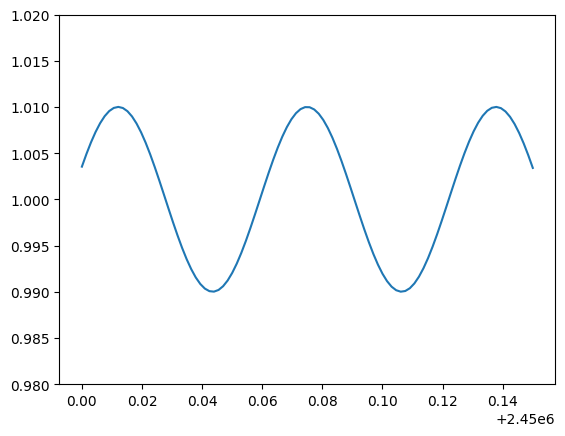

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prose.simulations import simulate_observation

time = np.linspace(0, 0.15, 100) + 2450000
target_dflux = 1 + np.sin(time*100)*1e-2

plt.plot(time, target_dflux)
_ = plt.ylim(0.98, 1.02)

This might be the differential flux of a variable star. Let’s now simulate the fits images associated with the observation of this target:

In [2]:
# so we have the same data
np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


here prose simulated comparison stars, their fluxes over time and some systematics noises.

## Explore FITS

The first thing we want to do is to see what is contained within our folder. For that we instantiate a [FitsManager](prose.FitsManager) object on our folder to describe its content

In [19]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
fm

Parsing FITS:   0%|          | 0/106 [00:00<?, ?it/s]

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
3,2023-02-07,A,,bias,prose,600,600,1
4,2023-02-07,A,,dark,prose,600,600,1
2,2023-02-07,A,a,flat,prose,600,600,4
1,2023-02-07,A,a,light,prose,600,600,100


We have 100 images of the prose target together with some calibration files.

## Extracting photometry

### Using a reference

In order to perform the photometric extraction of stars fluxes on all images, we will select a reference image from which we will extract:
- The stars positions, then reused and detected on all images (after being aligned to the reference)
- The global full-width at half-maximum (fwhm) of the PSF, to scale the apertures used in the [aperture photometry block](prose.blocks.AperturePhotometry)

In [20]:
from prose import FITSImage

ref = FITSImage(fm.all_images[0])

```{note}
[FITSImage](prose.FITSImage) is the primary function used to load a FITS image into an [Image](prose.Image) object. While other loaders wan be used, this loader is compatible with most of the images aquired from small to large-size ground based telescopes.
```

Let's now build a [Sequence](prose.Sequence) to process the reference image

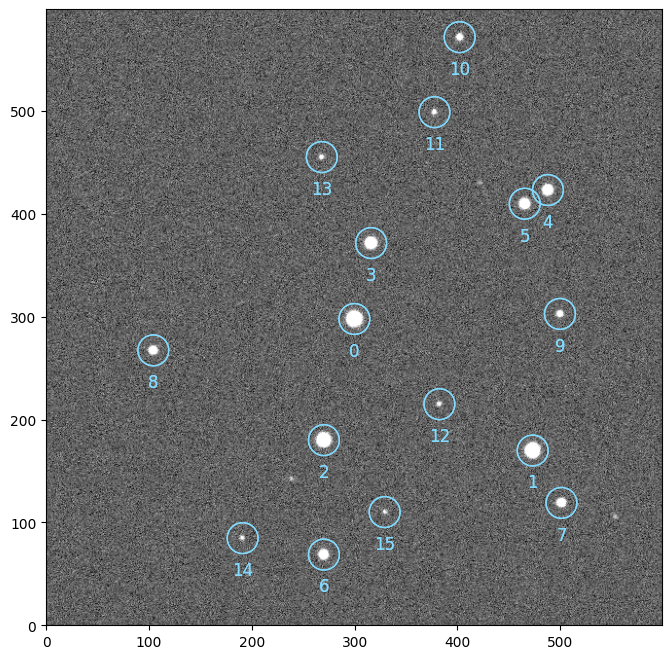

In [21]:
from prose import Sequence, blocks

calibration = Sequence([
    blocks.Calibration(darks=fm.all_darks, bias=fm.all_bias, flats=fm.all_flats),
    blocks.Trim(),
    blocks.PointSourceDetection(), # stars detection
    blocks.Cutouts(21),            # making stars cutouts
    blocks.MedianEPSF(),           # building PSF
    blocks.psf.Moffat2D(),         # modeling PSF
])

calibration.run(ref, show_progress=False)

ref.show()
ref.sources.plot()

```{tip}
You can use a Gaia query to define which stars you want the photometry from (e.g. if too faint to be detected here)
```

### Aperture photometry

We can now extract the photometry of these stars

In [23]:
from astropy.stats import gaussian_sigma_to_fwhm

radii = np.linspace(0.2, 4, 30)

photometry = Sequence([
    *calibration,                           # calibration
    blocks.AlignReferenceSources(ref),      # alignment
    blocks.CentroidQuadratic(),             # centroiding
    blocks.AperturePhotometry(radii=radii), # aperture photometry
    blocks.AnnulusBackground(),             # local background estimate
    blocks.GetFluxes()
])

photometry.run(fm.all_images, loader=FITSImage)

  0%|          | 0/100 [00:00<?, ?images/s]

Notice how we specified a `loader` to `photometry.run`, and instead of passing a list of [Image](prose.Image) objects, we passed a list of image paths. Although we cannot access each [Image](prose.Image) and its data individually, this allow to process a large amount of images without having to load them in memory. Instead, eadch image is loaded, processed and deleted in memory on the go.

## The [Fluxes](prose.Fluxes) object

The [GetFluxes](prose.blocks.GetFluxes) block provide a way to retrieve the fluxes computed by the [AperturePhotometry](prose.blocks.AperturePhotometry) minus the background estimated with [AnnulusBackground](prose.blocks.AnnulusBackground)

In [24]:
raw_fluxes = photometry[-1].fluxes

we can then produce the differential photometry with `autodiff`

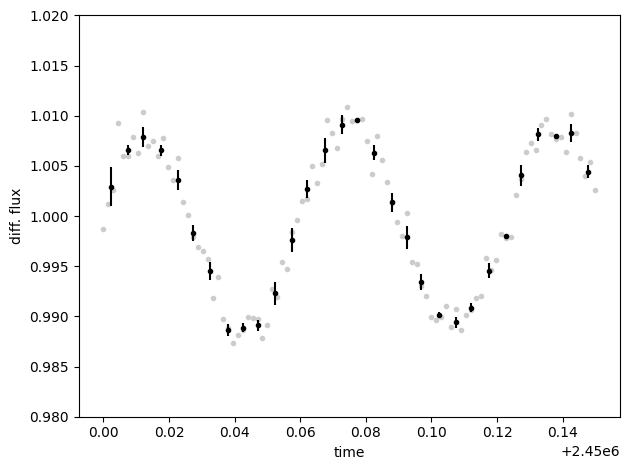

In [26]:
diff_fluxes = raw_fluxes.autodiff(target=0)
diff_fluxes.plot()
diff_fluxes.bin(0.005, True).errorbar()

plt.ylim(0.98, 1.02)
plt.xlabel("time"); plt.ylabel("diff. flux")
plt.tight_layout()

In [22]:
import shutil

shutil.rmtree(fits_folder)